In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
import warnings

warnings.simplefilter(action='ignore', category=UserWarning)
pd.set_option('mode.chained_assignment', None)
%matplotlib inline

# 指定要讀取的文件
data_dir = '/Volumes/T7/code/microprice/orderbook_data/binance_futures/ETHUSDT/'
target_files = [
  'binance_futures_orderbook_ETHUSDT_2025_07_30_00.parquet', 
  'binance_futures_orderbook_ETHUSDT_2025_07_30_01.parquet', 
  'binance_futures_orderbook_ETHUSDT_2025_07_30_02.parquet', 
  'binance_futures_orderbook_ETHUSDT_2025_07_30_03.parquet', 
  'binance_futures_orderbook_ETHUSDT_2025_07_30_04.parquet', 
  'binance_futures_orderbook_ETHUSDT_2025_07_30_05.parquet', 
  'binance_futures_orderbook_ETHUSDT_2025_07_30_06.parquet', 
  'binance_futures_orderbook_ETHUSDT_2025_07_30_07.parquet', 
  'binance_futures_orderbook_ETHUSDT_2025_07_30_08.parquet', 
  'binance_futures_orderbook_ETHUSDT_2025_07_30_09.parquet'
   
]

print(f"將讀取 {len(target_files)} 個指定的 ETH (market 0) 數據文件")

# 讀取並合併指定文件
eth_data_list = []
for filename in target_files:
    file_path = f"{data_dir}/{filename}"
    try:
        df_temp = pd.read_parquet(file_path)
        print(f"讀取文件: {filename}, 數據量: {len(df_temp)}")
        eth_data_list.append(df_temp)
    except Exception as e:
        print(f"讀取文件 {filename} 時出錯: {e}")

# 合併所有數據
if eth_data_list:
    eth_combined = pd.concat(eth_data_list, ignore_index=True)
    
    # 轉換時間戳並排序 - 修復時間戳格式問題
    print("正在處理時間戳格式...")
    eth_combined['timestamp'] = pd.to_datetime(eth_combined['timestamp'], format='mixed')
    eth_combined = eth_combined.sort_values('timestamp').reset_index(drop=True)
    
    print(f"\n聚合完成:")
    print(f"- 總數據量: {len(eth_combined):,}")
    print(f"- 時間範圍: {eth_combined['timestamp'].min()} 到 {eth_combined['timestamp'].max()}")
    print(f"- 數據列: {list(eth_combined.columns)}")
    
    # 顯示基本統計信息
    print(f"\n價格統計:")
    print(f"- 最佳買價範圍: {eth_combined['best_bid'].min():.2f} - {eth_combined['best_bid'].max():.2f}")
    print(f"- 最佳賣價範圍: {eth_combined['best_ask'].min():.2f} - {eth_combined['best_ask'].max():.2f}")
    
    
else:
    print("未能讀取任何數據文件")
    eth_combined = pd.DataFrame()

將讀取 10 個指定的 ETH (market 0) 數據文件
讀取文件: binance_futures_orderbook_ETHUSDT_2025_07_30_00.parquet, 數據量: 14280
讀取文件: binance_futures_orderbook_ETHUSDT_2025_07_30_01.parquet, 數據量: 14259
讀取文件: binance_futures_orderbook_ETHUSDT_2025_07_30_02.parquet, 數據量: 14245
讀取文件: binance_futures_orderbook_ETHUSDT_2025_07_30_03.parquet, 數據量: 14243
讀取文件: binance_futures_orderbook_ETHUSDT_2025_07_30_04.parquet, 數據量: 14265
讀取文件: binance_futures_orderbook_ETHUSDT_2025_07_30_05.parquet, 數據量: 13758
讀取文件: binance_futures_orderbook_ETHUSDT_2025_07_30_06.parquet, 數據量: 14223
讀取文件: binance_futures_orderbook_ETHUSDT_2025_07_30_07.parquet, 數據量: 14209
讀取文件: binance_futures_orderbook_ETHUSDT_2025_07_30_08.parquet, 數據量: 14203
讀取文件: binance_futures_orderbook_ETHUSDT_2025_07_30_09.parquet, 數據量: 8834
正在處理時間戳格式...

聚合完成:
- 總數據量: 136,519
- 時間範圍: 2025-07-29 23:59:59.983369 到 2025-07-30 09:37:07.369918
- 數據列: ['timestamp', 'sequence_id', 'exchange', 'symbol', 'event_type', 'bids', 'asks', 'best_bid', 'best_ask', 'best_bid_size', 

<Axes: >

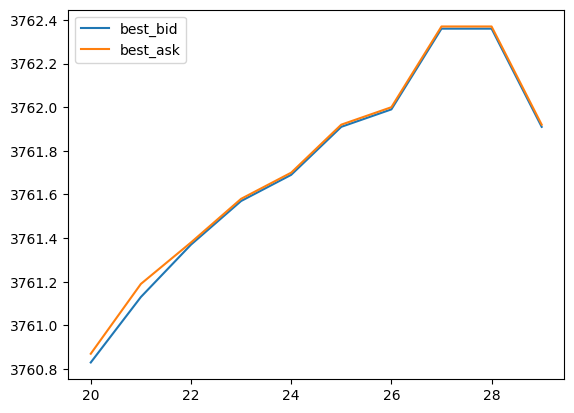

In [2]:
eth_combined[['best_bid', 'best_ask']][20:30].plot()

In [3]:
issues = []
neg_spread = (eth_combined['best_ask'] < eth_combined['best_bid']).sum()
if neg_spread > 0:
    issues.append(f"發現 {neg_spread} 筆負價差")
    
print(issues)

['發現 2355 筆負價差']


In [4]:
# 數據質量檢查
def data_quality_check(df):
    issues = []
    
    # 檢查負價差
    neg_spread = (df['ask'] < df['bid']).sum()
    if neg_spread > 0:
        issues.append(f"發現 {neg_spread} 筆負價差")
    
    # 檢查零價格
    zero_price = ((df['ask'] == 0) | (df['bid'] == 0)).sum()
    if zero_price > 0:
        issues.append(f"發現 {zero_price} 筆零價格")
    
    # 檢查異常大價差
    median_spread = (df['ask'] - df['bid']).median()
    large_spread = ((df['ask'] - df['bid']) > median_spread * 10).sum()
    if large_spread > 0:
        issues.append(f"發現 {large_spread} 筆異常大價差")
    
    return issues

### 數據概覽

In [5]:

# from scipy.linalg import block_diag

# def estimate(T, n_imb, n_spread):
#     """
#     Estimate market microstructure parameters from tick data.
    
#     Parameters:
#     T: DataFrame with columns ['imb_bucket', 'spread', 'dM', 'time', 'next_imb_bucket', 'next_spread']
#     n_imb: Number of imbalance buckets
#     n_spread: Number of spread levels
    
#     Returns:
#     G1, B, Q, R1, R2_counts, K: Market microstructure matrices and parameters
#     """
    
#     if len(T) == 0:
#         print("Warning: Empty dataset provided to estimate()")
#         return (np.zeros(n_imb * n_spread), np.eye(n_imb * n_spread), 
#                 np.eye(n_imb * n_spread), np.zeros((n_imb * n_spread, 4)), 
#                 np.eye(n_imb * n_spread), np.array([-0.01, -0.005, 0.005, 0.01]))
    
#     # Get actual dimensions
#     actual_n_imb = len(T['imb_bucket'].unique())
#     actual_n_spread = min(len(T['spread'].unique()), n_spread)
#     total_states = actual_n_imb * actual_n_spread
    
#     print(f"Processing with {actual_n_imb} imbalance buckets and {actual_n_spread} spread levels")
#     print(f"Total states: {total_states}")
#     print(f"Total data points: {len(T)}")
    
#     no_move = T[T['dM'] == 0]
    
#     # Initialize Q_counts to correct size
#     Q_counts = np.eye(total_states)  # Default to identity matrix
    
#     try:
#         if len(no_move) > 0:
#             no_move_counts = no_move.pivot_table(index=['next_imb_bucket'], 
#                                                 columns=['spread', 'imb_bucket'], 
#                                                 values='time',
#                                                 fill_value=0, 
#                                                 aggfunc='count').unstack()
            
#             print(f"Q matrix construction: no_move_counts shape = {no_move_counts.shape if hasattr(no_move_counts, 'shape') else len(no_move_counts)}")
            
#             # Rebuild Q_counts matrix
#             if actual_n_spread == 1:
#                 # Only one spread level
#                 matrix_size = actual_n_imb * actual_n_imb
#                 if len(no_move_counts) >= matrix_size:
#                     Q_counts = np.resize(np.array(no_move_counts[:matrix_size]), (actual_n_imb, actual_n_imb))
#                 else:
#                     Q_counts = np.eye(actual_n_imb)
#             else:
#                 # Multiple spread levels - use block diagonal structure
#                 Q_blocks = []
#                 for i in range(actual_n_spread):
#                     start_idx = i * actual_n_imb * actual_n_imb
#                     end_idx = (i + 1) * actual_n_imb * actual_n_imb
                    
#                     if end_idx <= len(no_move_counts):
#                         block = np.resize(np.array(no_move_counts[start_idx:end_idx]), (actual_n_imb, actual_n_imb))
#                     else:
#                         block = np.eye(actual_n_imb)
#                     Q_blocks.append(block)
                
#                 Q_counts = block_diag(*Q_blocks)
                
#     except Exception as e:
#         print(f"Warning: Error constructing Q matrix: {e}")
#         Q_counts = np.eye(total_states)
    
#     print(f"Q_counts final shape: {Q_counts.shape}")
    
#     # Build R1 matrix - ensure it matches Q_counts row count
#     try:
#         move_data = T[T['dM'] != 0]
#         if len(move_data) > 0:
#             move_counts = move_data.pivot_table(index=['dM'], 
#                                                columns=['spread', 'imb_bucket'], 
#                                                values='time',
#                                                fill_value=0, 
#                                                aggfunc='count').unstack()
            
#             print(f"R1 matrix construction: move_counts shape = {move_counts.shape if hasattr(move_counts, 'shape') else len(move_counts)}")
            
#             # R1 matrix must have same row count as Q_counts
#             expected_shape = (Q_counts.shape[0], 4)  # Use Q_counts row count
#             R_counts = np.zeros(expected_shape)
            
#             # Fill R_counts based on actual state mapping
#             available_data = min(len(move_counts), expected_shape[0] * expected_shape[1])
#             if available_data > 0:
#                 flat_data = np.array(move_counts.flatten()[:available_data])
#                 R_counts.flat[:available_data] = flat_data
#         else:
#             R_counts = np.zeros((Q_counts.shape[0], 4))
#     except Exception as e:
#         print(f"Warning: Error constructing R1 matrix: {e}")
#         R_counts = np.zeros((Q_counts.shape[0], 4))
    
#     print(f"R_counts final shape: {R_counts.shape}")
    
#     # Now matrix sizes should match
#     T1 = np.concatenate((Q_counts, R_counts), axis=1).astype(float)
#     print(f"T1 combined shape: {T1.shape}")
    
#     # Normalize rows
#     for i in range(T1.shape[0]):
#         row_sum = T1[i].sum()
#         if row_sum > 0:
#             T1[i] = T1[i] / row_sum
#         else:
#             # If row is all zeros, set diagonal element to 1
#             if i < Q_counts.shape[1]:
#                 T1[i, i] = 1.0
    
#     Q = T1[:, :Q_counts.shape[1]]
#     R1 = T1[:, Q_counts.shape[1]:]
    
#     K = np.array([-0.01, -0.005, 0.005, 0.01])
    
#     # Build R2 matrix
#     try:
#         if len(move_data) > 0:
#             move_counts_R2 = move_data.pivot_table(index=['spread', 'imb_bucket'], 
#                                                   columns=['next_spread', 'next_imb_bucket'], 
#                                                   values='time',
#                                                   fill_value=0, 
#                                                   aggfunc='count')
            
#             expected_r2_shape = (Q_counts.shape[0], Q_counts.shape[0])
#             R2_counts = np.eye(expected_r2_shape[0])
            
#             if len(move_counts_R2) > 0:
#                 available_r2 = min(len(move_counts_R2), expected_r2_shape[0] * expected_r2_shape[1])
#                 flat_r2 = np.array(move_counts_R2.values.flatten()[:available_r2])
#                 temp_r2 = np.zeros(expected_r2_shape)
#                 temp_r2.flat[:available_r2] = flat_r2
#                 R2_counts = temp_r2
#         else:
#             R2_counts = np.eye(Q_counts.shape[0])
#     except Exception as e:
#         print(f"Warning: Error constructing R2 matrix: {e}")
#         R2_counts = np.eye(Q_counts.shape[0])
    
#     # Calculate final matrices
#     try:
#         regularization = 1e-10
#         inv_matrix = np.linalg.inv(np.eye(Q.shape[0]) - Q + regularization * np.eye(Q.shape[0]))
#         G1 = np.dot(np.dot(inv_matrix, R1), K)
#         B = np.dot(inv_matrix, R2_counts)
#     except np.linalg.LinAlgError as e:
#         print(f"Warning: Singular matrix detected: {e}")
#         G1 = np.zeros(Q.shape[0])
#         B = np.eye(Q.shape[0])
    
#     return G1, B, Q, R1, R2_counts, K

In [6]:
lighter = eth_combined.copy()

## 3. 數據預處理

In [7]:
df = pd.DataFrame()
df['time'] = lighter['timestamp']
df['ask'] = lighter['best_ask']
df['bid'] = lighter['best_bid']
df['bs'] = lighter['best_bid_size']
df['as'] = lighter['best_ask_size']
df['mid'] = lighter['mid_price']

# 修正加權中間價公式：根據不平衡度加權
df['imb'] = df['bs'] / (df['bs'] + df['as'])
df['wmid'] = df['bid'] * df['imb'] + df['ask'] * (1 - df['imb'])

# 確保數據類型正確
df = df.astype({
    'ask': float,
    'bid': float,
    'bs': float,
    'as': float,
    'mid': float,
    'imb': float,
    'wmid': float
})

print(f"Data shape: {df.shape}")
print(f"Imb range: {df['imb'].min():.6f} to {df['imb'].max():.6f}")
print(f"Unique imbalance values: {df['imb'].nunique()}")

Data shape: (136519, 8)
Imb range: 0.000002 to 0.999998
Unique imbalance values: 135768


In [8]:
data_quality_check(df)

['發現 2355 筆負價差', '發現 344 筆異常大價差']

原始數據價差分佈:

價差百分比分佈:
價差 -13.7400: 0.00%
價差 -13.5300: 0.00%
價差 -13.4400: 0.01%
價差 -13.1400: 0.00%
價差 -13.1200: 0.00%
價差 -13.0700: 0.00%
價差 -12.9900: 0.00%
價差 -12.9500: 0.00%
價差 -12.8500: 0.00%
價差 -12.8000: 0.00%
價差 -12.7800: 0.00%
價差 -12.6000: 0.00%
價差 -12.4800: 0.00%
價差 -11.8300: 0.00%
價差 -11.7900: 0.00%
價差 -11.4600: 0.01%
價差 -11.3900: 0.00%
價差 -11.2800: 0.00%
價差 -11.2400: 0.00%
價差 -11.2000: 0.00%
價差 -11.0500: 0.00%
價差 -10.9900: 0.00%
價差 -10.8100: 0.01%
價差 -10.7200: 0.00%
價差 -10.7000: 0.00%
價差 -10.5300: 0.00%
價差 -10.4700: 0.01%
價差 -10.4400: 0.01%
價差 -10.4200: 0.02%
價差 -10.2100: 0.00%
價差 -10.1700: 0.00%
價差 -10.1300: 0.01%
價差 -10.0400: 0.00%
價差 -10.0300: 0.00%
價差 -9.9400: 0.00%
價差 -9.8200: 0.01%
價差 -9.7800: 0.01%
價差 -9.7600: 0.00%
價差 -9.6700: 0.00%
價差 -9.6200: 0.01%
價差 -9.2500: 0.02%
價差 -9.2400: 0.00%
價差 -9.1900: 0.00%
價差 -9.1100: 0.00%
價差 -9.0700: 0.00%
價差 -8.8900: 0.00%
價差 -8.6900: 0.01%
價差 -8.6800: 0.01%
價差 -8.6400: 0.00%
價差 -8.5400: 0.00%
價差 -8.4500: 0.00%
價差 -8.2900: 0.01%
價差 -8.2500

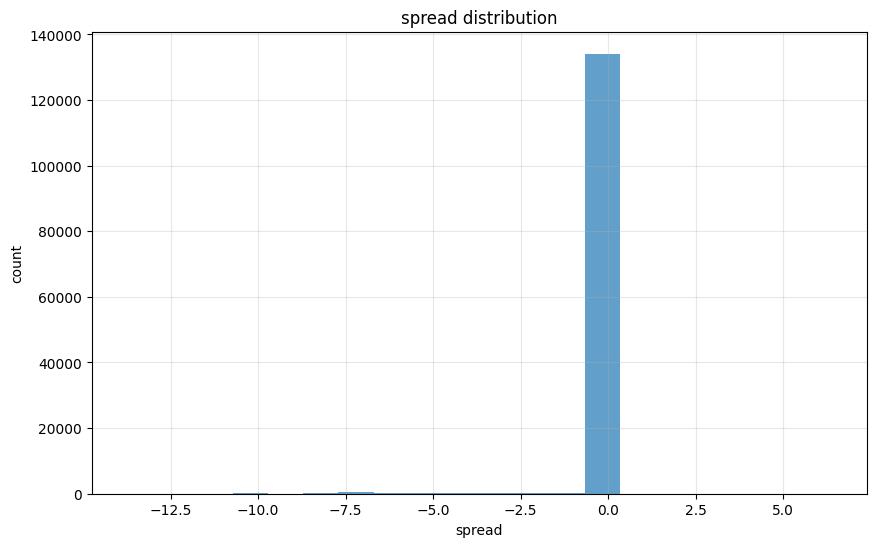

In [9]:
# 檢查原始數據中的價差分佈
print("原始數據價差分佈:")
spread_values = df['ask'] - df['bid']
spread_counts = spread_values.value_counts().sort_index()

# 計算價差的百分比分佈
spread_pct = spread_counts / len(spread_values) * 100
print("\n價差百分比分佈:")
for spread, pct in spread_pct.items():
    print(f"價差 {spread:.4f}: {pct:.2f}%")

# 繪製價差分佈直方圖
plt.figure(figsize=(10, 6))
plt.hist(spread_values, bins=20, alpha=0.7)
plt.title('spread distribution')
plt.xlabel('spread')
plt.ylabel('count')
plt.grid(True, alpha=0.3)
plt.show()


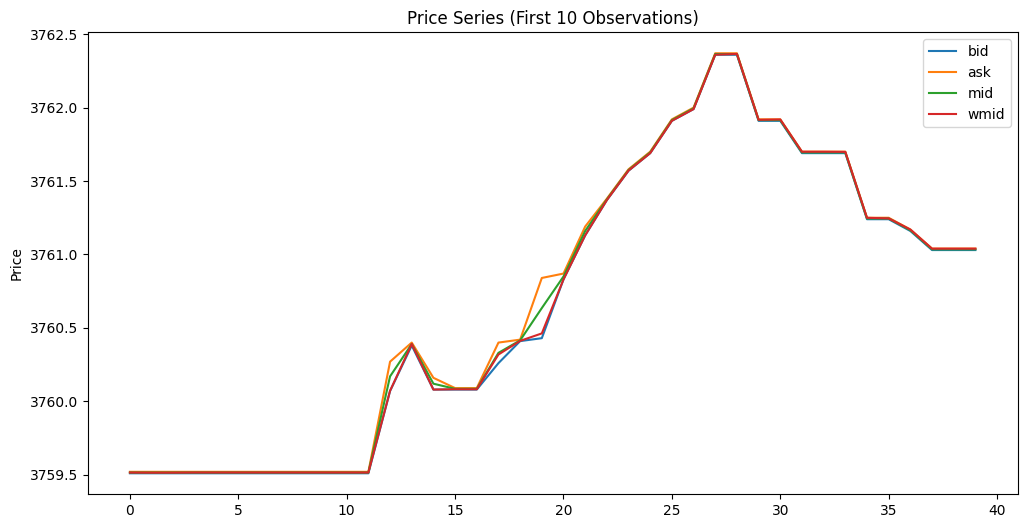

In [10]:
df[['bid', 'ask', 'mid', 'wmid']][:40].plot(figsize=(12, 6), title='Price Series (First 10 Observations)')
plt.ylabel('Price')
plt.legend()
plt.show()

## 4. 微觀價格模型函數

### 數據對稱化函數

In [11]:
def prep_data_sym(T, n_imb, dt, n_spread):
    spread = T.ask - T.bid
    ticksize = np.round(min(spread.loc[spread > 0]) * 100) / 100
    T.spread = T.ask - T.bid
    # adds the spread and mid prices
    T['spread'] = np.round((T['ask'] - T['bid']) / ticksize) * ticksize
    T['mid'] = (T['bid'] + T['ask']) / 2
    # filter out spreads >= n_spread
    T = T.loc[(T.spread <= n_spread * ticksize) & (T.spread > 0)]
    T['imb'] = T['bs'] / (T['bs'] + T['as'])
    # discretize imbalance into percentiles
    try:
        T['imb_bucket'] = pd.qcut(T['imb'], n_imb, labels=False, duplicates='drop')
    except ValueError as e:
        print(f"Warning: qcut failed with {n_imb} buckets: {e}")
        # 降低bucket數量重試
        n_imb_reduced = min(n_imb, T['imb'].nunique())
        if n_imb_reduced < 2:
            n_imb_reduced = 2
        print(f"Retrying with {n_imb_reduced} buckets")
        T['imb_bucket'] = pd.qcut(T['imb'], n_imb_reduced, labels=False, duplicates='drop')
    
    T['next_mid'] = T['mid'].shift(-dt)
    # step ahead state variables
    T['next_spread'] = T['spread'].shift(-dt)
    T['next_time'] = T['time'].shift(-dt)
    T['next_imb_bucket'] = T['imb_bucket'].shift(-dt)
    # step ahead change in price
    T['dM'] = np.round((T['next_mid'] - T['mid']) / ticksize * 2) * ticksize / 2
    T = T.loc[(T.dM <= ticksize * 1.1) & (T.dM >= -ticksize * 1.1)].dropna()
    
    if len(T) == 0:
        print("Warning: No data remaining after filtering")
        return T, ticksize
    
    # symmetrize data
    T2 = T.copy(deep=True)
    T2['imb_bucket'] = n_imb - 1 - T2['imb_bucket']
    T2['next_imb_bucket'] = n_imb - 1 - T2['next_imb_bucket']
    T2['dM'] = -T2['dM']
    T2['mid'] = -T2['mid']
    T3 = pd.concat([T, T2], ignore_index=True)
    
    return T3, ticksize

Note
1. 計算最小跳動單位(ticksize)
2. 標準化價差為tick的整數倍
3. 過濾異常價差和負價差
4. 計算不平衡度並分成n_imb個桶
5. 計算下一時刻的狀態變量(next_mid, next_spread等)
6. 計算價格變動(dM)並過濾異常值
7. 對數據進行對稱化處理，增加樣本數量
8. 創建數據的鏡像副本，將買方優勢轉為賣方優勢
9. 反轉不平衡度桶、價格變動方向等
10. 這種對稱化處理可以增加樣本數量，提高模型穩定性


### 馬可夫鏈參數估計函數 : revise here 
- based on observed tick price to adjust ! 

In [ ]:
def estimate(T):
    no_move = T[T['dM'] == 0]
    no_move_counts = no_move.pivot_table(index=['next_imb_bucket'], 
                     columns=['spread', 'imb_bucket'], 
                     values='time',
                     fill_value=0, 
                     aggfunc='count').unstack()
    Q_counts = np.resize(np.array(no_move_counts[0:(n_imb*n_imb)]), (n_imb, n_imb))
    # loop over all spreads and add block matrices
    for i in range(1, n_spread):
        Qi = np.resize(np.array(no_move_counts[(i*n_imb*n_imb):(i+1)*(n_imb*n_imb)]), (n_imb, n_imb))
        Q_counts = block_diag(Q_counts, Qi)
    
    # 使用所有非零價格變動，但按方向分組
    move_data = T[(T['dM'] != 0)]
    # 創建方向列：1表示上漲，0表示下跌
    move_data['direction'] = (move_data['dM'] > 0).astype(int)
    
    # 按方向分組統計
    move_counts = move_data.pivot_table(
        index=['direction'],  # 使用方向而不是具體的dM值
        columns=['spread', 'imb_bucket'], 
        values='time',
        fill_value=0, 
        aggfunc='count'
    ).unstack()

    # 重新排列以確保下跌在前，上漲在後
    if 0 in move_counts.index and 1 in move_counts.index:
        move_counts = move_counts.reindex([0, 1])
    
    # 修改R_counts為2列，對應K值[-0.01, 0.01]
    R_counts = np.resize(np.array(move_counts), (n_imb*n_spread, 2))
    T1 = np.concatenate((Q_counts, R_counts), axis=1).astype(float)
    for i in range(0, n_imb*n_spread):
        row_sum = T1[i].sum()
        if row_sum > 0:  # 避免除以零
            T1[i] = T1[i] / row_sum
    Q = T1[:, 0:(n_imb*n_spread)]
    R1 = T1[:, (n_imb*n_spread):]

    # 使用正確尺度的K值
    K = np.array([-0.01, 0.01])
    
    # 構建R2矩陣 - 使用相同的方向分組數據
    move_counts_R2 = move_data.pivot_table(
        index=['spread', 'imb_bucket'], 
        columns=['next_spread', 'next_imb_bucket'], 
        values='time',
        fill_value=0, 
        aggfunc='count'
    )

    R2_counts = np.resize(np.array(move_counts_R2), (n_imb*n_spread, n_imb*n_spread))
    T2 = np.concatenate((Q_counts, R2_counts), axis=1).astype(float)

    for i in range(0, n_imb*n_spread):
        row_sum = T2[i].sum()
        if row_sum > 0:  # 避免除以零
            T2[i] = T2[i] / row_sum
    R2 = T2[:, (n_imb*n_spread):]
    Q2 = T2[:, 0:(n_imb*n_spread)]
    
    # 添加正則化以提高數值穩定性
    regularization = 1e-8
    inv_matrix = np.linalg.inv(np.eye(n_imb*n_spread) - Q + regularization * np.eye(n_imb*n_spread))
    G1 = np.dot(np.dot(inv_matrix, R1), K)
    B = np.dot(inv_matrix, R2)
    
    return G1, B, Q, Q2, R1, R2, K

SyntaxError: keyword argument repeated: index (1992389885.py, line 21)

Note : 
1. 分離價格不變(dM=0)和價格變動(dM≠0)的數據
2. 構建Q矩陣：價格不變時的狀態轉移概率
- 使用block_diag函數為不同價差等級構建塊對角矩陣
3. 構建R1矩陣：價格變動幅度的概率分佈
- 記錄不同狀態下價格變動的幅度分佈
4. 構建R2矩陣：價格變動後新狀態的概率分佈
- 記錄價格變動後系統轉移到新狀態的概率
5. 標準化矩陣，使每行和為1（轉為概率）
6. 計算微觀價格調整G1 = (I-Q)^(-1) * R1 * K
- 這是第一階微觀價格調整
7. 計算遞歸矩陣B = (I-Q)^(-1) * R2
- 用於計算高階微觀價格調整

### 微觀價格調整繪圖函數

In [ ]:
def plot_Gstar(ticker, G1, B, T):
    # 計算高階調整，使用更穩定的方法
    G2 = np.dot(B, G1) + G1
    G3 = G2 + np.dot(np.dot(B, B), G1)
    G4 = G3 + np.dot(np.dot(np.dot(B, B), B), G1)
    G5 = G4 + np.dot(np.dot(np.dot(np.dot(B, B), B), B), G1)
    G6 = G5 + np.dot(np.dot(np.dot(np.dot(np.dot(B, B), B), B), B), G1)
    
    # 檢查G6是否包含異常值
    g6_min = G6.min()
    g6_max = G6.max()
    print(f"G6 range: {g6_min:.6f} to {g6_max:.6f}")
    
    # 如果G6範圍過大，可能需要裁剪
    clip_threshold = 0.005
    if g6_min < -clip_threshold or g6_max > clip_threshold:
        print(f"Warning: G6 contains values outside of [{-clip_threshold}, {clip_threshold}], clipping for display")
        G6_display = np.clip(G6, -clip_threshold, clip_threshold)
    else:
        G6_display = G6
    
    plt.figure(figsize=(10, 6))
    
    # 繪製基準線
    plt.plot(imb, np.zeros(n_imb), label='Mid adj', marker='o')
    
    # 繪製加權中間價調整線 (線性從-0.002到0.002)
    weighted_mid_adj = np.linspace(-0.002, 0.002, n_imb)
    plt.plot(imb, weighted_mid_adj, label='Weighted mid adj', marker='o')
    
    # 繪製不同價差的微觀價格調整線
    for i in range(0, n_spread):
        spread_adj = G6_display[(0 + i * n_imb):(n_imb + i * n_imb)]
        plt.plot(imb, spread_adj, label=f"spread = {i + 1} tick adj", marker='o')
    
    # 設置圖表範圍和標籤
    plt.ylim(-0.003, 0.003)  # 調整Y軸範圍以更好地顯示調整
    plt.grid(True, alpha=0.3)  # 添加網格線
    plt.legend(loc='upper left')
    plt.title(ticker + ' adjustments')
    plt.xlabel('Imbalance')
    plt.ylabel('Price adjustment')
    plt.show()
    
    # 額外添加一個圖表，顯示各個價差等級的調整差異
    plt.figure(figsize=(10, 6))
    
    # 繪製不同價差的微觀價格調整線
    colors = ['g', 'r', 'b', 'purple']
    for i in range(0, n_spread):
        spread_adj = G6_display[(0 + i * n_imb):(n_imb + i * n_imb)]
        plt.plot(imb, spread_adj, label=f"spread = {i + 1} tick", marker='o', color=colors[i % len(colors)])
        
        # 添加填充區域，顯示與加權中間價的差異
        plt.fill_between(imb, weighted_mid_adj, spread_adj, alpha=0.2, color=colors[i % len(colors)])
    
    plt.grid(True, alpha=0.3)
    plt.legend(loc='upper left')
    plt.title(f'{ticker} - Microprice Adjustments vs Weighted Mid')
    plt.xlabel('Imbalance')
    plt.ylabel('Price adjustment')
    plt.ylim(-0.003, 0.003)
    plt.show()
    
    return G6

Note: 
1. 計算高階調整G2-G6
- G2 = BG1 + G1
- G3 = G2 + B²G1
- ...
- G6 = G5 + B⁵G1
2. 繪製四條線：
- 中間價調整（恆為0）
- wmid（線性，從-0.005到0.005）
- 1 tick價差的微觀價格調整
- 2 tick價差的微觀價格調整


## 5. Binance 價格分析

### 設置分析參數

In [ ]:
n_imb = 10      # 不平衡度分成10個桶 (0-1之間)
n_spread = 2   # 考慮2種價差：1 tick和2 tick
dt = 1          # 向前看1步
ticker = 'Binance'  # 交易所名稱

print("Starting data preparation...")
T, ticksize = prep_data_sym(df, n_imb, dt, n_spread)

print(f"\nData preparation completed:")
print(f"- Tick size: {ticksize}")
print(f"- Processed samples: {len(T)}")

if len(T) > 0:
    print(f"- Price range: {T['mid'].min():.2f} - {T['mid'].max():.2f}")
    print(f"- Imbalance buckets: {T['imb_bucket'].nunique()}")
    print(f"- Spread levels: {T['spread'].nunique()}")
else:
    print("- No valid data after filtering")

# 定義不平衡度向量，用於繪圖
imb = np.linspace(0, 1, n_imb)

Note 
imb  = (0, 1) --> consecutive 

1. 功能解析：
- 設置模型參數：10個不平衡度桶、2種價差等級、向前看1步

2. 輸出分析：
- Tick size為0.01
- 處理後的樣本數為214,400，是原始數據的約1.57倍（因為對稱化處理）
- 價格範圍從-3797.66到3797.66（負值是對稱化的結果）
- 有10個不平衡度桶和2個價差等級

In [ ]:
T

In [ ]:
# 分析實際價格變動分佈
def analyze_price_movements(T, ticksize):
    # 過濾非零價格變動
    price_changes = T.loc[T['dM'] != 0, 'dM'].values
    
    # 計算基本統計量
    mean_change = np.mean(price_changes)
    median_change = np.median(price_changes)
    std_change = np.std(price_changes)
    
    # 計算分位數
    percentiles = [5, 25, 50, 75, 95]
    quantiles = np.percentile(price_changes, percentiles)
    
    print(f"價格變動分析 (以 tick 為單位):")
    print(f"- 平均變動: {mean_change/ticksize:.4f} ticks")
    print(f"- 中位數變動: {median_change/ticksize:.4f} ticks")
    print(f"- 標準差: {std_change/ticksize:.4f} ticks")
    print("\n分位數 (以 tick 為單位):")
    for p, q in zip(percentiles, quantiles):
        print(f"- {p}%: {q/ticksize:.4f} ticks")
    
    # 繪製直方圖
    plt.figure(figsize=(10, 6))
    plt.hist(price_changes/ticksize, bins=50, alpha=0.7)
    plt.title('Price Movement Distribution (in ticks)')
    plt.xlabel('Price Change (ticks)')
    plt.ylabel('Frequency')
    plt.axvline(x=0, color='r', linestyle='--', alpha=0.5)
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return price_changes, mean_change, std_change

# 執行分析
price_changes, mean_change, std_change = analyze_price_movements(T, ticksize)

### 執行微觀價格估計

In [ ]:
if len(T) > 0:
    print("\nRunning microprice estimation...")
    
    # 運行估計
    G1, B, Q, Q2, R1, R2, K = estimate(T)
    
    print("\nEstimation completed:")
    print(f"- G1 shape: {G1.shape}")
    print(f"- B shape: {B.shape}")
    print(f"- Adjustment range: {G1.min():.6f} to {G1.max():.6f}")
    
    print("\nGenerating microprice plot...")
    G6 = plot_Gstar(ticker, G1, B, T)
    
else:
    print("\nSkipping estimation - no valid data after preprocessing")

In [ ]:
W=np.linalg.matrix_power(B,100)
for i in range(0,n_spread):
    plt.plot(imb,W[0][(0+i*n_imb):(n_imb+i*n_imb)],label="spread = "+str(i+1)+" tick ",marker='o')
    
plt.legend(loc='upper left')
plt.title('stationary distribution')
plt.xlabel('Imbalance')

In [ ]:
# 檢查是否達到穩態
W_99 = np.linalg.matrix_power(B, 99)
W_100 = np.linalg.matrix_power(B, 100)
diff = np.max(np.abs(W_100 - W_99))
print(f"最大差異: {diff}")
if diff < 1e-10:
    print("已達到穩態")
else:
    print("尚未達到穩態，需要更多次冪")

In [ ]:
# 特徵值分析
eigenvalues = np.linalg.eigvals(B)
eigenvalues = sorted(np.abs(eigenvalues), reverse=True)
print(f"最大特徵值: {eigenvalues[0]}")
print(f"第二大特徵值: {eigenvalues[1]}")
print(f"收斂速度因子: {eigenvalues[1]/eigenvalues[0]}")

Revision 

In [ ]:
# 修改後的穩態分佈計算與繪圖代碼
# 1. 首先確保B是一個有效的隨機矩陣
B_normalized = B.copy()
for i in range(B.shape[0]):
    row_sum = np.sum(B_normalized[i, :])
    if row_sum > 0:  # 避免除以零
        B_normalized[i, :] = B_normalized[i, :] / row_sum

# 2. 使用特徵值方法直接計算穩態分佈
eigenvalues, eigenvectors = np.linalg.eig(B_normalized.T)  # 注意使用轉置矩陣
# 找到特徵值為1(或最接近1)的特徵向量
idx = np.argmax(np.abs(eigenvalues))
stationary = np.real(eigenvectors[:, idx])  # 取實部
# 歸一化使和為1
stationary = stationary / np.sum(stationary)

# 3. 繪製穩態分佈
plt.figure(figsize=(12, 6))
for i in range(0, n_spread):
    start_idx = i * n_imb
    end_idx = (i + 1) * n_imb
    plt.plot(imb, stationary[start_idx:end_idx], 
             label=f"spread = {i + 1} tick", marker='o')

plt.legend(loc='upper left')
plt.title('Stationary Distribution (Eigenvalue Method)')
plt.xlabel('Imbalance')
plt.ylabel('Probability')
plt.grid(True, alpha=0.3)
plt.show()

# 4. 輸出特徵值檢查
print(f"修正後最大特徵值: {np.max(np.abs(eigenvalues)):.10f}")
print(f"與1的差異: {np.abs(np.max(np.abs(eigenvalues)) - 1):.10f}")

# 5. 檢查穩態分佈的有效性
print(f"穩態分佈和: {np.sum(stationary):.10f}")
print(f"穩態分佈最小值: {np.min(stationary):.10f}")
print(f"穩態分佈最大值: {np.max(stationary):.10f}")

# 6. 可選：使用冪迭代法驗證結果
W_power = np.ones(B_normalized.shape[0]) / B_normalized.shape[0]  # 初始均勻分佈
max_iter = 10000
tolerance = 1e-10
for iter in range(max_iter):
    W_new = np.dot(W_power, B_normalized)
    diff = np.max(np.abs(W_new - W_power))
    W_power = W_new
    if diff < tolerance:
        print(f"冪迭代法收斂於 {iter+1} 次迭代")
        break
    if iter == max_iter - 1:
        print("冪迭代法未收斂")

# 7. 比較兩種方法的結果
if 'W_power' in locals():
    diff_methods = np.max(np.abs(stationary - W_power))
    print(f"特徵值法與冪迭代法的最大差異: {diff_methods:.10f}")
    
    # 繪製比較圖
    plt.figure(figsize=(12, 6))
    for i in range(0, n_spread):
        start_idx = i * n_imb
        end_idx = (i + 1) * n_imb
        plt.plot(imb, stationary[start_idx:end_idx], 
                 label=f"Eigenvalue: spread = {i + 1} tick", marker='o')
        plt.plot(imb, W_power[start_idx:end_idx], 
                 label=f"Power: spread = {i + 1} tick", linestyle='--')
    
    plt.legend(loc='upper left')
    plt.title('Comparison of Stationary Distribution Methods')
    plt.xlabel('Imbalance')
    plt.ylabel('Probability')
    plt.grid(True, alpha=0.3)
    plt.show()

Stationary dist : 
- Y軸代表穩態概率分佈，即長期均衡狀態下，系統處於各個不平衡度狀態的概率。數值越高，表示系統越容易處於該不平衡度狀態。

- 峰值位置表示市場最常處於的不平衡狀態

- 價差與不平衡度的關係：
    - 當不平衡度極低(接近0)時，市場傾向於維持1 tick價差
    - 當不平衡度較高(接近0.8)時，市場傾向於擴大到2 tick價差
    - 這符合市場微觀結構理論：高不平衡度通常伴隨更大價差


- 市場動態：
    - 這可能反映了市場參與者的行為模式：當買方興趣增強時，賣方傾向於提高價格並擴大價差
    - 賣方可能更謹慎，在買方壓力增加時要求更高的風險溢價（更大的價差）


- 優化交易執行：
    - 在不平衡度接近0時，使用市價單買入可能獲得較好的執行價格（因為價差小）
    - 在不平衡度接近0.8時，使用限價單賣出可能更有利（因為買方壓力大）

### 6. 連續時間點不平衡度分析

In [ ]:
## 6. Consecutive Time Points Imbalance Analysis

# Set analysis parameters
window_sizes = [2, 3, 4]  # Consecutive time points window sizes
imb_thresholds = [0.01, 0.99]  # Imbalance thresholds, below 0.2 is extreme sell-side, above 0.8 is extreme buy-side

# Prepare original data (using non-symmetrized data)
orig_df = df.copy()
orig_df['next_mid'] = orig_df['mid'].shift(-1)
orig_df['price_change'] = orig_df['next_mid'] - orig_df['mid']
orig_df['direction'] = np.sign(orig_df['price_change'])

# Calculate results for different window sizes
for window in window_sizes:
    print(f"\nAnalyzing consecutive {window} time points of imbalance:")
    
    # Create rolling window extreme imbalance markers
    orig_df[f'extreme_low_{window}'] = orig_df['imb'].rolling(window=window).apply(
        lambda x: 1 if (x < imb_thresholds[0]).all() else 0, raw=True
    ).fillna(0).astype(int)
    
    orig_df[f'extreme_high_{window}'] = orig_df['imb'].rolling(window=window).apply(
        lambda x: 1 if (x > imb_thresholds[1]).all() else 0, raw=True
    ).fillna(0).astype(int)
    
    # Analyze price movements after extreme low imbalance
    low_imb_next = orig_df.loc[orig_df[f'extreme_low_{window}'] == 1, 'direction']
    if len(low_imb_next) > 0:
        down_pct = (low_imb_next < 0).mean() * 100
        up_pct = (low_imb_next > 0).mean() * 100
        neutral_pct = (low_imb_next == 0).mean() * 100
        print(f"After consecutive {window} time points of extreme low imbalance (imb < {imb_thresholds[0]}):")
        print(f"  - Price decrease probability: {down_pct:.2f}%")
        print(f"  - Price increase probability: {up_pct:.2f}%")
        print(f"  - Price unchanged probability: {neutral_pct:.2f}%")
        print(f"  - Sample size: {len(low_imb_next)}")
    else:
        print(f"Sample size for consecutive {window} time points of extreme low imbalance (imb < {imb_thresholds[0]}) is 0")
    
    # Analyze price movements after extreme high imbalance
    high_imb_next = orig_df.loc[orig_df[f'extreme_high_{window}'] == 1, 'direction']
    if len(high_imb_next) > 0:
        down_pct = (high_imb_next < 0).mean() * 100
        up_pct = (high_imb_next > 0).mean() * 100
        neutral_pct = (high_imb_next == 0).mean() * 100
        print(f"After consecutive {window} time points of extreme high imbalance (imb > {imb_thresholds[1]}):")
        print(f"  - Price decrease probability: {down_pct:.2f}%")
        print(f"  - Price increase probability: {up_pct:.2f}%")
        print(f"  - Price unchanged probability: {neutral_pct:.2f}%")
        print(f"  - Sample size: {len(high_imb_next)}")
    else:
        print(f"Sample size for consecutive {window} time points of extreme high imbalance (imb > {imb_thresholds[1]}) is 0")

# Visualize the relationship between imbalance and price changes
plt.figure(figsize=(12, 8))

# Plot scatter: imbalance vs price change
plt.scatter(orig_df['imb'], orig_df['price_change'], alpha=0.3, s=10)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.axvline(x=imb_thresholds[0], color='g', linestyle='--', alpha=0.5)
plt.axvline(x=imb_thresholds[1], color='g', linestyle='--', alpha=0.5)

# Add trend line
z = np.polyfit(orig_df['imb'], orig_df['price_change'], 1)
p = np.poly1d(z)
plt.plot(np.sort(orig_df['imb']), p(np.sort(orig_df['imb'])), "r--", alpha=0.8)

plt.title('Relationship Between Imbalance and Price Change')
plt.xlabel('Imbalance')
plt.ylabel('Price Change')
plt.grid(True, alpha=0.3)
plt.show()

# Analyze price changes across different imbalance ranges
imb_bins = [0, 0.05, 0.1, 0.5, 0.9, 0.95, 1.0]
orig_df['imb_bin'] = pd.cut(orig_df['imb'], bins=imb_bins, labels=[f"{imb_bins[i]}-{imb_bins[i+1]}" for i in range(len(imb_bins)-1)])

# Calculate average price change and directional accuracy for each range
bin_stats = orig_df.groupby('imb_bin').agg(
    avg_change=('price_change', 'mean'),
    up_prob=('direction', lambda x: (x > 0).mean() * 100),
    down_prob=('direction', lambda x: (x < 0).mean() * 100),
    neutral_prob=('direction', lambda x: (x == 0).mean() * 100),
    count=('direction', 'count')
)

print("\nPrice change statistics for different imbalance ranges:")
print(bin_stats)

# Visualize up/down probabilities for different imbalance ranges
plt.figure(figsize=(12, 6))
x = np.arange(len(bin_stats.index))
width = 0.35

plt.bar(x - width/2, bin_stats['up_prob'], width, label='Up Probability (%)', color='green', alpha=0.7)
plt.bar(x + width/2, bin_stats['down_prob'], width, label='Down Probability (%)', color='red', alpha=0.7)

plt.xlabel('Imbalance Range')
plt.ylabel('Probability (%)')
plt.title('Price Direction Probabilities for Different Imbalance Ranges')
plt.xticks(x, bin_stats.index, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()




Frequency of signals 

In [ ]:
# 連續有2個 (0.01, 0.99 ) imbalance : 
tot = 1431 + 1339
time = 9.5 * 60 

tot / time 

In [ ]:
# only using imbalance (0.05, 0.95)
tot_sig =  12331 + 12209
tot_sig / time 

In [ ]:
print("win / loss ratio ")
print(" short: ",  54.51 / 1.33 ) 
print("long: ",  44.66 / 1.57 )

濾網：篩選訊號

1. 波動率條件化：在高波動期間提高閾值，低波動期間降低閾值。
2. 交易量過濾：只在交易量異常時段（高於平均值1.5倍以上）執行策略。
3. 訂單流加速度
4. 價格壓力 




In [ ]:
# 分析訂單流量變化
def order_flow_enhancement(df):
    # 計算買賣訂單流量比率
    df['buy_flow'] = df['bs'].diff().clip(lower=0)
    df['sell_flow'] = df['as'].diff().clip(lower=0)
    df['flow_ratio'] = df['buy_flow'] / (df['buy_flow'] + df['sell_flow']).replace(0, 1)
    
    # 計算訂單流量加速度
    df['flow_accel'] = df['flow_ratio'].diff().rolling(3).sum()
    
    # 識別強勢流量信號
    strong_flow = (df['flow_ratio'] > 0.8) & (df['flow_accel'] > 0)
    
    return strong_flow

In [ ]:
# 計算價格壓力指標
def price_pressure_index(orderbook_data):
    # 計算買賣深度比率
    buy_depth = orderbook_data['bids'].apply(lambda x: sum([qty for price, qty in x[:5]]))
    sell_depth = orderbook_data['asks'].apply(lambda x: sum([qty for price, qty in x[:5]]))
    
    # 計算價格壓力
    pressure = (buy_depth - sell_depth) / (buy_depth + sell_depth)
    
    # 識別極端壓力
    extreme_pressure = pressure.abs() > pressure.abs().quantile(0.9)
    
    return extreme_pressure